In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import json
import os

from pathlib import Path
from PIL import Image

In [2]:
root = Path('./dsr/')

with open(root / 'train_valid_test_split.json', 'r') as f:
    split = json.load(f)

print('Number of scenes - Train:', len(split['train']))
print('Number of scenes - Valid:', len(split['valid']))
print('Number of scenes - Test:', len(split['test']))

Number of scenes - Train: 100
Number of scenes - Valid: 50
Number of scenes - Test: 50


In [3]:
class DSRDataset(torch.utils.data.Dataset):

    ALTITUDES = (10, 20, 30, 40, 50, 70, 80, 100, 120, 140)
    DEFAULT_IMAGE = 'hasselblad0.png'
    DEFAULT_TARGET = 'tele.png'
    
    def __init__(self, root, scenes, height=None, transform=None):
        self.root = root
        self.transform = transform
        self.scenes = scenes

        self.pairs = []

        for scene in scenes:
            if height is not None:
                pairs_height = self.get_pairs(root, scene, height)

                if len(pairs_height) > 0:
                    self.pairs.extend(pairs_height)
            else:
                for altitude in self.ALTITUDES:
                    pairs_height = self.get_pairs(root, scene, altitude)

                    if len(pairs_height) > 0:
                        self.pairs.extend(pairs_height)
                
        print(f'Loaded {len(self.pairs)} pairs for scenes {scenes} and height {height}')
                    
    def load_image(self, path):
        return Image.open(path)
            
    def get_pairs(self, root, scene, height):
        pairs = []
        filepath = root / scene / str(height)
    
        if not filepath.exists():
            return pairs

        directories = [name for name in os.listdir(filepath) if os.path.isdir(os.path.join(filepath, name))]
        directories.sort()

        for directory in directories:
            pairs.append((filepath / directory / self.DEFAULT_IMAGE, filepath / directory / self.DEFAULT_TARGET))

        return pairs
            
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        image_path, target_path = self.pairs[idx]
        image = self.load_image(image_path)
        target = self.load_image(target_path)

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor()
])

dataset_30 = DSRDataset(root, split['train'], height=30, transform=transform)
dataset_80 = DSRDataset(root, split['train'], height=80, transform=transform)
dataset_140 = DSRDataset(root, split['train'], height=140, transform=transform)

print('Number of samples - 30m:', len(dataset_30))
print('Number of samples - 80m:', len(dataset_80))
print('Number of samples - 140m:', len(dataset_140))

Loaded 508 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', '0057', '0058', '0059', '0060', '0061', '0063', '0065', '0067', '0069', '0070', '0072', '0074', '0077', '0078', '0080', '0081', '0170', '0087', '0088', '0090', '0092', '0093', '0095', '0096', '0098', '0099', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0112', '0114', '0116', '0230', '0118', '0120', '0121', '0123', '0124', '0128', '0130', '0131', '0133', '0134', '0135', '0136', '0138', '0139', '0141', '0143', '0171', '0145', '0147', '0150', '0174', '0176', '0157', '0158', '0159', '0160', '0161', '0163', '0178', '0181', '0186', '0187', '0183', '0185', '0189', '0190', '0191', '0194', '0195', '0200', '0201', '0202', '0203', '0204', '0208', '0218', '0223'] and height 30
Loaded 528 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', 

In [5]:
dataset = DSRDataset(root, split['train'], transform=transform)

print('Number of samples - 80m:', len(dataset))

Loaded 5175 pairs for scenes ['0029', '0032', '0034', '0035', '0037', '0038', '0040', '0166', '0043', '0044', '0046', '0048', '0049', '0051', '0052', '0054', '0057', '0058', '0059', '0060', '0061', '0063', '0065', '0067', '0069', '0070', '0072', '0074', '0077', '0078', '0080', '0081', '0170', '0087', '0088', '0090', '0092', '0093', '0095', '0096', '0098', '0099', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0112', '0114', '0116', '0230', '0118', '0120', '0121', '0123', '0124', '0128', '0130', '0131', '0133', '0134', '0135', '0136', '0138', '0139', '0141', '0143', '0171', '0145', '0147', '0150', '0174', '0176', '0157', '0158', '0159', '0160', '0161', '0163', '0178', '0181', '0186', '0187', '0183', '0185', '0189', '0190', '0191', '0194', '0195', '0200', '0201', '0202', '0203', '0204', '0208', '0218', '0223'] and height None
Number of samples - 80m: 5175


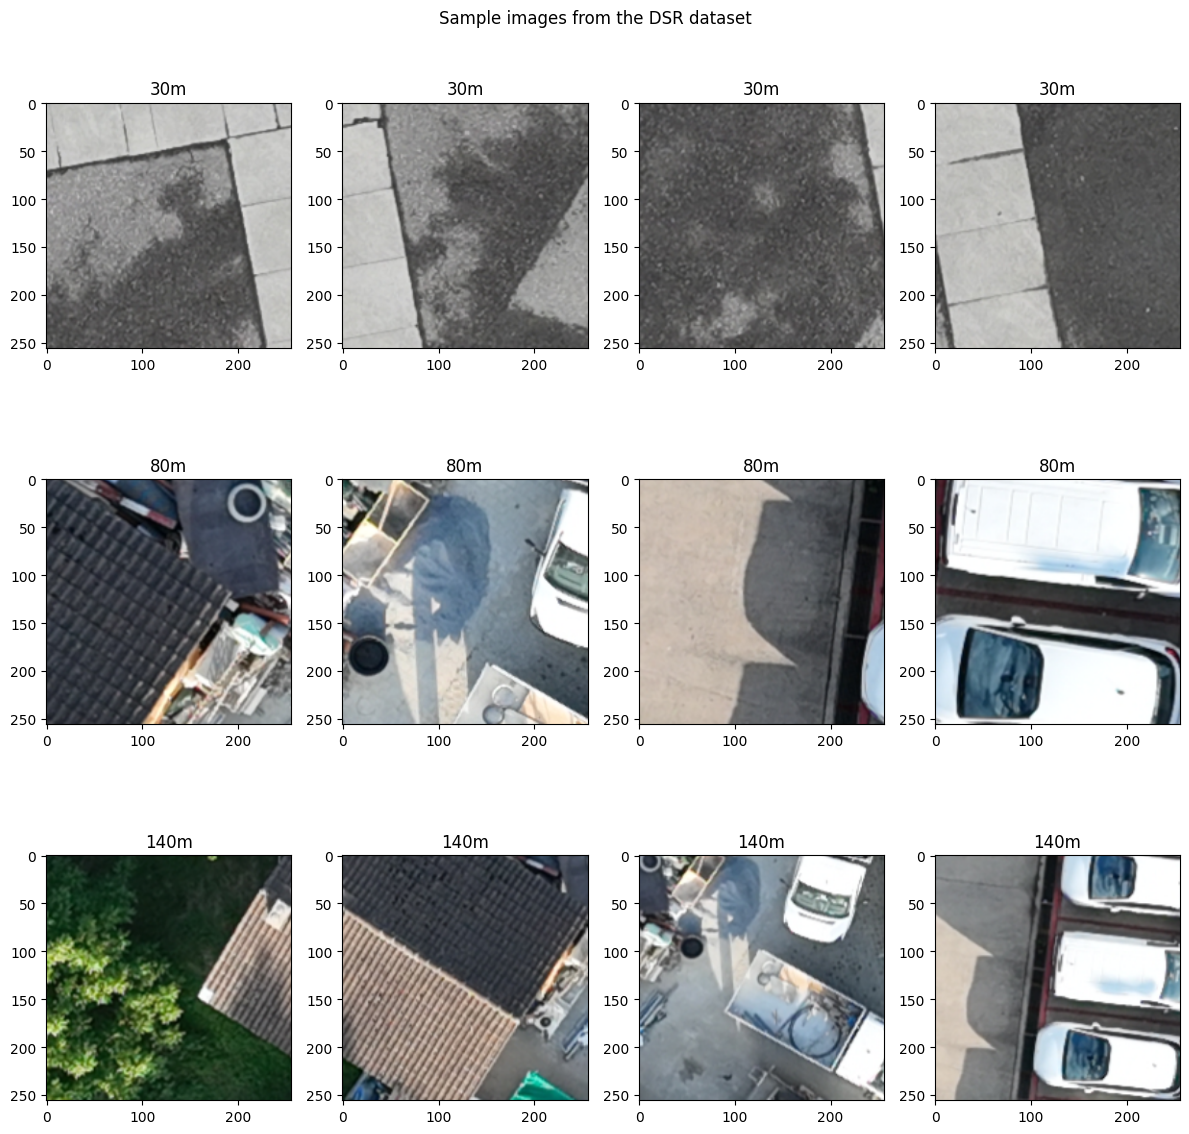

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(12, 12))
offset = 42

for i in range(4):
    image = dataset_30[i + offset][0]
    axs[0, i].imshow(image.permute(1, 2, 0))
    axs[0, i].set_title('30m')
    
    image = dataset_80[i + offset][0]
    axs[1, i].imshow(image.permute(1, 2, 0))
    axs[1, i].set_title('80m')
    
    image = dataset_140[i + offset][0]
    axs[2, i].imshow(image.permute(1, 2, 0))
    axs[2, i].set_title('140m')

plt.suptitle('Sample images from the DSR dataset')
plt.tight_layout()

Text(0.5, 1.0, 'Target')

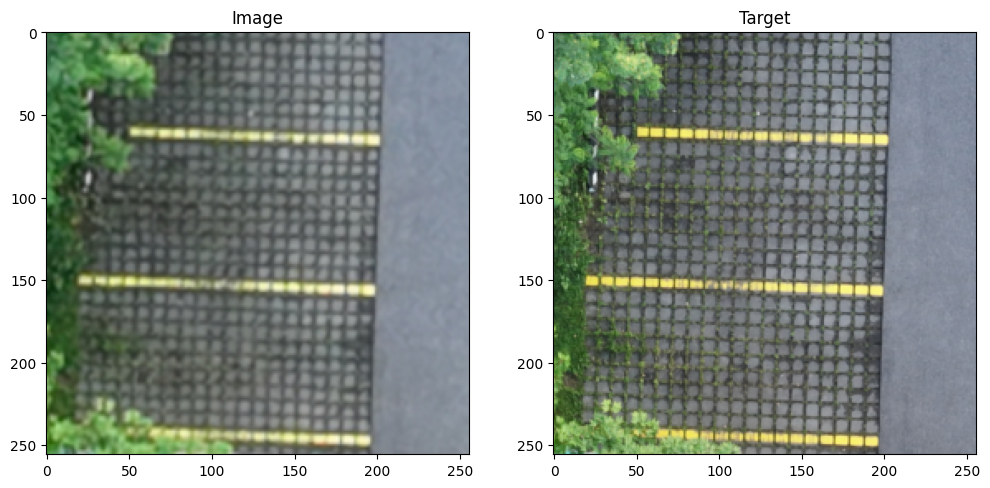

In [24]:
image, target = dataset_140[3]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image.permute(1, 2, 0))
axs[0].set_title('Image')

axs[1].imshow(target.permute(1, 2, 0))
axs[1].set_title('Target')

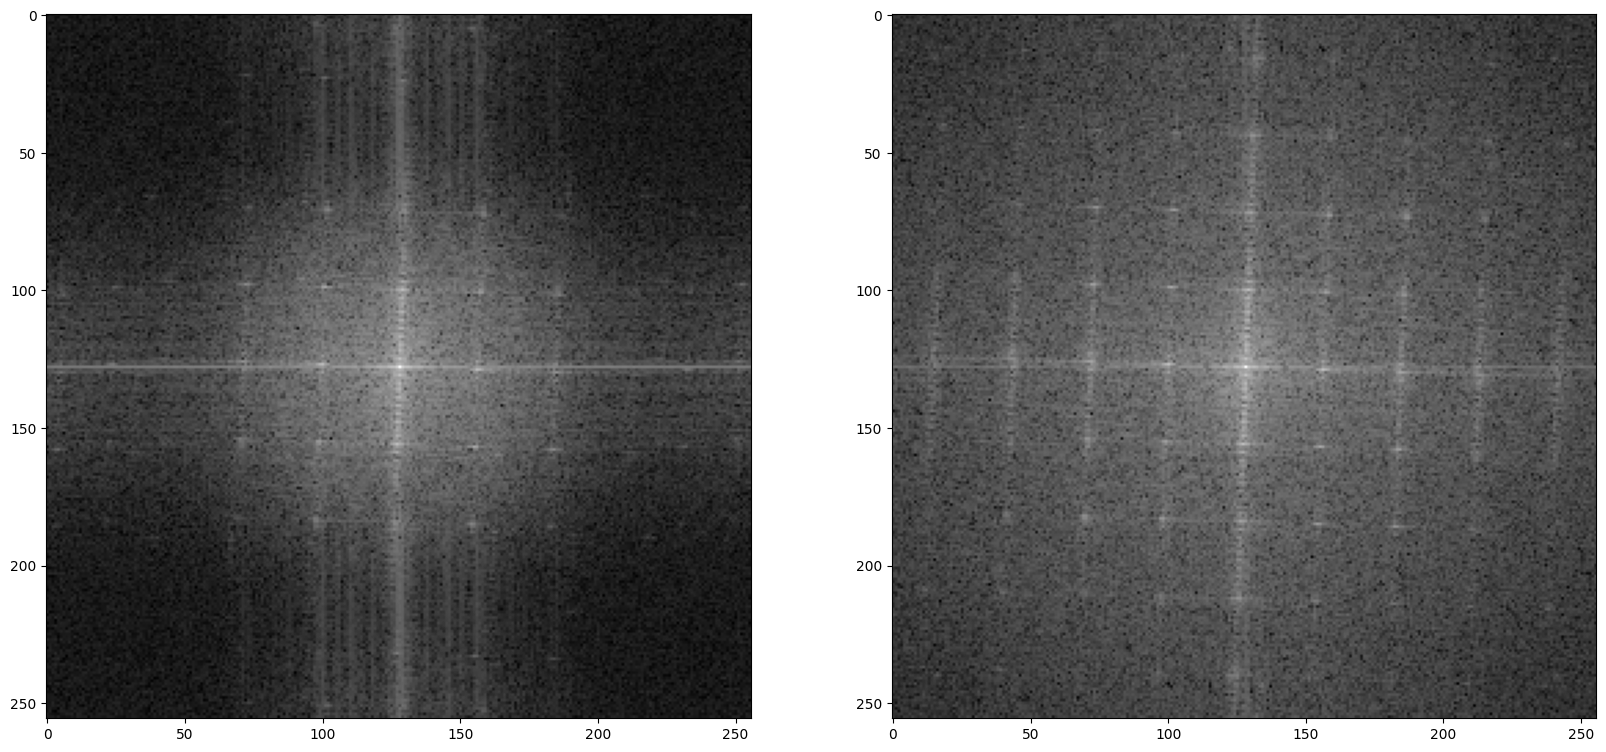

In [26]:
import matplotlib.pyplot as plt
import skimage
import numpy as np
import numpy.fft as fft

image_fft = fft.fft2(image[0].numpy())
target_fft = fft.fft2(target[0].numpy())
modfft_image = np.log(np.abs(fft.fftshift(image_fft)) + 0.1)
modfft_target = np.log(np.abs(fft.fftshift(target_fft)) + 0.1)

fig, axs = plt.subplots(1, 2, figsize=(20,20))
axs[0].imshow(modfft_image, cmap='gray')
axs[1].imshow(modfft_target, cmap='gray')
plt.show()